# Анализ бизнес-показателей развлекательного приложения

Несмотря на огромные вложения в рекламу, последние несколько месяцев компания, запустившая развлекательное приложение Procrastinate Pro+, терпит убытки. Наша задача — разобраться в причинах и помочь компании выйти в плюс.

Есть данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года:
лог сервера с данными об их посещениях,
выгрузка их покупок за этот период,
рекламные расходы.

Нам предстоит изучить:
откуда приходят пользователи и какими устройствами они пользуются,
сколько стоит привлечение пользователей из различных рекламных каналов;
сколько денег приносит каждый клиент,
когда расходы на привлечение клиента окупаются,
какие факторы мешают привлечению клиентов.

### Описание данных
В нашем распоряжении три датасета. Файл `visits_info_short.csv` хранит лог сервера с информацией о посещениях сайта, `orders_info_short.csv` — информацию о заказах, а `costs_info_short.csv` — информацию о расходах на рекламу.
- Структура `visits_info_short.csv`:
 - `User Id` — уникальный идентификатор пользователя,
 - `Region` — страна пользователя,
 - `Device` — тип устройства пользователя,
 - `Channel` — идентификатор источника перехода,
 - `Session Start` — дата и время начала сессии,
 - `Session End` — дата и время окончания сессии.
- Структура `orders_info_short.csv`:
 - `User Id` — уникальный идентификатор пользователя,
 - `Event Dt` — дата и время покупки,
 - `Revenue` — сумма заказа.
- Структура `costs_info_short.csv`:
 - `dt` — дата проведения рекламной кампании,
 - `Channel` — идентификатор рекламного источника,
 - `costs` — расходы на эту кампанию.
 
### Цели исследования
 
1. Выделить причины неэффективности привлечения пользователей.
2. Сформулировать рекомендации для отдела маркетинга.

### Ход исследования

Данные я получу из трёх файлов. О качестве данных ничего неизвестно, поэтому перед тем как приступить к ходу исследования, понадобится обзор данных. Я проверю данные на ошибки и оценю их влияние на исследование. Затем задам необходимые функции для анализа, после чего приступлю к исследованию.

Таким образом исследование пройдёт в шесть этапов:
1. Загрузка данных и подготовка их к анализу
2. Создание функций для расчёта и анализа LTV, ROI, удержания и конверсии.
3. Исследовательский анализ данных
4. Маркетинг
5. Оценка окупаемости рекламы
6. Общий вывод

### 1. Загрузка данных и подготовка их к анализу

Загрузим данные о визитах, заказах и рекламных расходах из CSV-файлов в переменные.

Изучим данные и выполним предобработку. Есть ли в данных пропуски и дубликаты? Убедимся, что типы данных во всех колонках соответствуют сохранённым в них значениям. Обратим внимание на столбцы с датой и временем.

In [3]:
#импорт библиотек

import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
%matplotlib inline

In [4]:
#работаем локально, но не забываем и об онлайне

try:
    visits = pd.read_csv('/datasets/visits_info_short.csv')
except:
    visits = pd.read_csv('C:/Users/salpa/Downloads/visits_info_short.csv')
    
try:
    orders = pd.read_csv('/datasets/orders_info_short.csv')
except:
    orders = pd.read_csv('C:/Users/salpa/Downloads/orders_info_short.csv')
    
try:
    costs = pd.read_csv('/datasets/costs_info_short.csv')
except:
    costs = pd.read_csv('C:/Users/salpa/Downloads/costs_info_short.csv')

#### Предобработка visits

In [5]:
visits.head()

User Id         Region   Device  Channel        Session Start  \
0  981449118918  United States   iPhone  organic  2019-05-01 02:36:01   
1  278965908054  United States   iPhone  organic  2019-05-01 04:46:31   
2  590706206550  United States      Mac  organic  2019-05-01 14:09:25   
3  326433527971  United States  Android   TipTop  2019-05-01 00:29:59   
4  349773784594  United States      Mac  organic  2019-05-01 03:33:35   

           Session End  
0  2019-05-01 02:45:01  
1  2019-05-01 04:47:35  
2  2019-05-01 15:32:08  
3  2019-05-01 00:54:25  
4  2019-05-01 03:57:40

In [6]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


In [7]:
visits.duplicated().sum()

0

In [8]:
visits.isna().sum()

User Id          0
Region           0
Device           0
Channel          0
Session Start    0
Session End      0
dtype: int64

In [9]:
#переименовываем столбцы
visits.columns = ['user_id', 'region', 'device', 'channel', 'session_start', 'session_end']

In [10]:
#приводим столбцы с датами в нужный формат
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])

In [11]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   user_id        309901 non-null  int64         
 1   region         309901 non-null  object        
 2   device         309901 non-null  object        
 3   channel        309901 non-null  object        
 4   session_start  309901 non-null  datetime64[ns]
 5   session_end    309901 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 14.2+ MB


#### Предобработка orders

In [12]:
orders.head()

User Id             Event Dt  Revenue
0  188246423999  2019-05-01 23:09:52     4.99
1  174361394180  2019-05-01 12:24:04     4.99
2  529610067795  2019-05-01 11:34:04     4.99
3  319939546352  2019-05-01 15:34:40     4.99
4  366000285810  2019-05-01 13:59:51     4.99

In [13]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


In [14]:
orders.duplicated().sum()

0

In [15]:
orders.isna().sum()

User Id     0
Event Dt    0
Revenue     0
dtype: int64

In [16]:
#переименовываем столбцы
orders.columns = ['user_id', 'event_dt', 'revenue']

In [17]:
#приводим столбец с датами в нужный формат
orders['event_dt'] = pd.to_datetime(orders['event_dt'])

In [18]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   40212 non-null  int64         
 1   event_dt  40212 non-null  datetime64[ns]
 2   revenue   40212 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 942.6 KB


#### Предобработка costs

In [19]:
costs.head()

dt   Channel  costs
0  2019-05-01  FaceBoom  113.3
1  2019-05-02  FaceBoom   78.1
2  2019-05-03  FaceBoom   85.8
3  2019-05-04  FaceBoom  136.4
4  2019-05-05  FaceBoom  122.1

In [20]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


In [21]:
costs.duplicated().sum()

0

In [22]:
costs.isna().sum()

dt         0
Channel    0
costs      0
dtype: int64

In [23]:
#переименовываем столбцы
costs.columns = ['dt', 'channel', 'costs']

In [24]:
#приводим столбец с датами в нужный формат
costs['dt'] = pd.to_datetime(costs['dt']).dt.date

In [25]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


- Были произведены обзор и обработка трёх файлов, с которыми предстоит работа. Переименованы столбцы (нижний регистр, без пробелов) и изменён тип данных. Пропусков и дубликтов не обнаружено.

### 2. Создание функций для расчёта и анализа LTV, ROI, удержания и конверсии.

Это функции для вычисления значений метрик:

- `get_profiles()` — для создания профилей пользователей,
- `get_retention()` — для подсчёта Retention Rate,
- `get_conversion()` — для подсчёта конверсии,
- `get_ltv()` — для подсчёта LTV.

А также функции для построения графиков:

- `filter_data()` — для сглаживания данных,
- `plot_retention()` — для построения графика Retention Rate,
- `plot_conversion()` — для построения графика конверсии,
- `plot_ltv_roi` — для визуализации LTV и ROI.

#### Функция для создания профилей пользователей

In [26]:
def get_profiles(sessions, orders, ad_costs):
    # передадим в функцию расчета профиля данные о рекламных затратах (фрейм ad_costs)
    
    # сортируем сессии по id пользователя и дате для того,чтобы работал first
    # находим первые значения для параметров пользователя - будем считать их основными 
    profiles = (sessions.sort_values(by = ['user_id', 'session_start'])           
                        .groupby('user_id').agg({'session_start' : 'first',       
                                                 'channel': 'first',
                                                 'device': 'first',
                                                 'region': 'first'})                                 
                        .rename(columns = {'session_start' : 'first_ts'})  
                        .reset_index()  # вернем все данные из индекса в колонки                                           
               )
    # определим дату первого посещеня 
    # и начало месяца первого посещения - они понадобятся нам при когортном анализе
    profiles['dt'] = profiles['first_ts'].dt.date                                 
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')     
    
    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())   
            
    # к данным о рекламных затратах добавим количества привлеченных пользователей
    new_users = profiles.groupby(['dt', 'channel']).agg({'user_id': 'nunique'}).rename(columns = {'user_id': 'unique_users'}).reset_index()
    ad_costs = ad_costs.merge(new_users, on = ['dt', 'channel'], how = 'left')
    
    # найдем среднюю стоимость привлечения пользователя
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']
    
    # присоединим данные к профилям пользователей информацию о средней стоимости привлечения в день привлечения пользователя из нужного источника
    profiles = profiles.merge(ad_costs[['dt', 'channel', 'acquisition_cost']], on = ['dt', 'channel'], how = 'left')
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0) # органические пользователи будут стоить 0
    
    return profiles

#### Функция для расчёта удержания

In [27]:
def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

#### Функция для расчёта конверсии

In [28]:
def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis=1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time


#### Функция для расчёта LTV и ROI

In [29]:
def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    ) 

#### Функция для сглаживания данных

In [30]:
def filter_data(df, window):
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

#### Функция для построения графика Retention Rate

In [31]:
def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show() 

#### Функция для построения графика конверсии

In [32]:
def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

#### Функция для визуализации LTV и ROI

In [33]:
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

### 3. Исследовательский анализ данных

- Составим профили пользователей. Определим минимальную и максимальную даты привлечения пользователей.
- Выясним из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. Построим таблицу, отражающую количество пользователей и долю платящих из каждой страны.
- Узнаем какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. Построим таблицу, отражающую количество пользователей и долю платящих для каждого устройства.
- Изучим рекламные источники привлечения и определите каналы, из которых пришло больше всего платящих пользователей. Построим таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.

In [34]:
profiles = get_profiles(visits, orders, costs)

In [35]:
profiles['dt'] = profiles['first_ts'].dt.date

In [36]:
print('Минимальная дата привлечения пользователей:', profiles['dt'].min())
print('Максимальная дата привлечения пользователей:', profiles['dt'].max())

Минимальная дата привлечения пользователей: 2019-05-01
Максимальная дата привлечения пользователей: 2019-10-27


In [37]:
countries = profiles.groupby('region').agg({'user_id': 'nunique', 'payer': ['sum', 'mean']})
countries.columns = ['всего пользователей', 'платящих пользователей', 'доля платящих']
countries['доля платящих'] = [f'{x:,.1%}' for x in countries['доля платящих']]
countries.sort_values(by='всего пользователей', ascending=False)

всего пользователей  платящих пользователей доля платящих
region                                                                  
United States               100002                    6902          6.9%
UK                           17575                     700          4.0%
France                       17450                     663          3.8%
Germany                      14981                     616          4.1%

- В приложение приходят пользователи из четырёх стран: США, Великобритании, Франции и Германии.
- Больше всего платящих пользователей приходится на США с долей почти 7%.

In [38]:
device = profiles.groupby('device').agg({'user_id': 'nunique', 'payer': ['sum', 'mean']})
device.columns = ['всего пользователей', 'платящих пользователей', 'доля платящих']
device['доля платящих'] = [f'{x:,.1%}' for x in device['доля платящих']]
device.sort_values(by='всего пользователей', ascending=False)

всего пользователей  платящих пользователей доля платящих
device                                                            
iPhone                 54479                    3382          6.2%
Android                35032                    2050          5.9%
PC                     30455                    1537          5.0%
Mac                    30042                    1912          6.4%

- Пользователи используют такие устройства как iPhone, Android, PC и Mac.
- Доля платящих пользователей больше всего у Mac - 6,4%. Но у iPhone и Android не сильно меньше - 6,2% и 5,9% соотвествтенно.

In [39]:
channel = profiles.groupby('channel').agg({'user_id': 'nunique', 'payer': ['sum', 'mean']})
channel.columns = ['всего пользователей', 'платящих пользователей', 'доля платящих']
channel['доля платящих'] = [f'{x:,.1%}' for x in channel['доля платящих']]
channel.sort_values(by='всего пользователей', ascending=False)

всего пользователей  платящих пользователей доля платящих
channel                                                                      
organic                           56439                    1160          2.1%
FaceBoom                          29144                    3557         12.2%
TipTop                            19561                    1878          9.6%
OppleCreativeMedia                 8605                     233          2.7%
LeapBob                            8553                     262          3.1%
WahooNetBanner                     8553                     453          5.3%
RocketSuperAds                     4448                     352          7.9%
MediaTornado                       4364                     156          3.6%
YRabbit                            4312                     165          3.8%
AdNonSense                         3880                     440         11.3%
lambdaMediaAds                     2149                     225         10.5%

- Больше всего платящих пользователей пришло из каналов FaceBoom(12,2%), AdNonSense(11,3%) и lambdaMediaAds(10,5%).

### 4. Маркетинг

- Посчитаем общую сумму расходов на маркетинг.
- Выясним как траты распределены по рекламным источникам, то есть сколько денег потратили на каждый источник.
- Построим визуализацию динамики изменения расходов во времени (по неделям и месяцам) по каждому источнику. Постараемся отразить это на одном графике.
- Узнаем сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника. Используем профили пользователей.

In [40]:
print('Общие расходы на маркетинг:', round(costs['costs'].sum()))

Общие расходы на маркетинг: 105497


In [41]:
channel_costs = costs.pivot_table(index=['channel'], values='costs', aggfunc='sum')\
.reset_index().sort_values(by='costs', ascending=False)
channel_costs['share'] = channel_costs['costs'] / 105497
channel_costs.columns = ['канал', 'траты', 'процент трат']
channel_costs['процент трат'] = [f'{x:,.1%}' for x in channel_costs['процент трат']]
channel_costs

канал     траты процент трат
6              TipTop  54751.30        51.9%
1            FaceBoom  32445.60        30.8%
7      WahooNetBanner   5151.00         4.9%
0          AdNonSense   3911.25         3.7%
4  OppleCreativeMedia   2151.25         2.0%
5      RocketSuperAds   1833.00         1.7%
2             LeapBob   1797.60         1.7%
9      lambdaMediaAds   1557.60         1.5%
3        MediaTornado    954.48         0.9%
8             YRabbit    944.22         0.9%

- Больше половины общих трат ушли на TipTop. Чуть меньше трети - на FaceBoom. В случае FaceBoom - это несёт свои плоды, ведь оттуда пришла самая большая доля платящих пользователей. А вот траты на TipTop себя не совсем оправдывают.

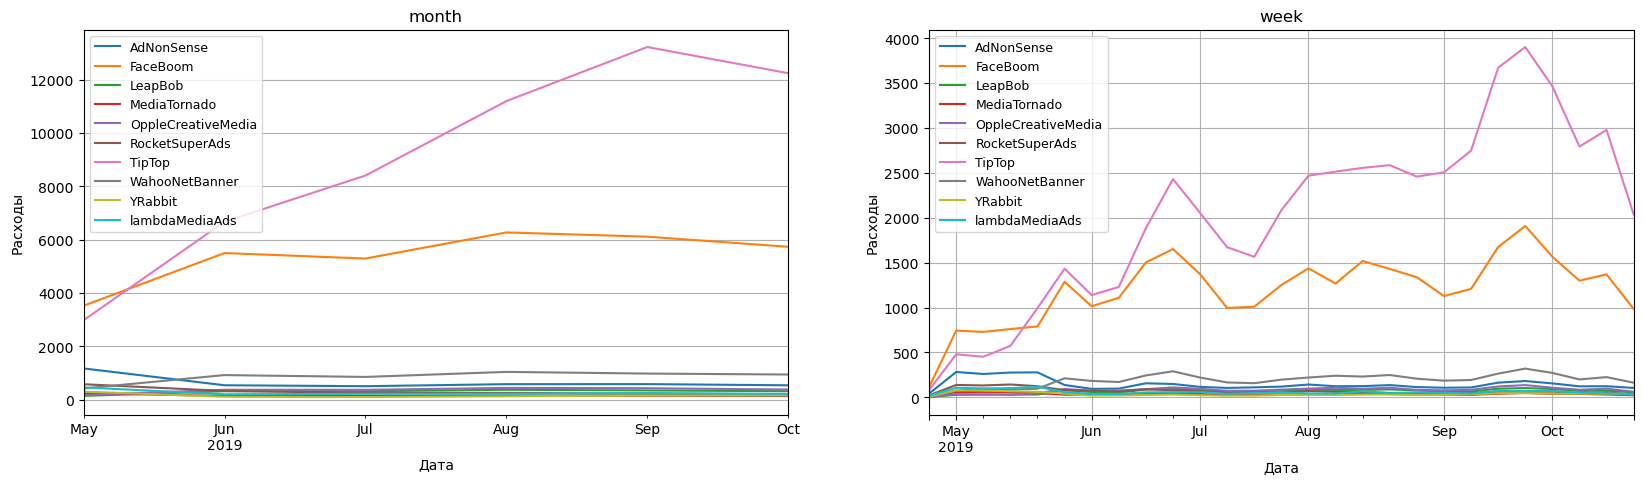

In [42]:
costs['month'] = costs['dt'].astype('datetime64[M]') 
costs['week'] = costs['dt'].astype('datetime64[W]')

columns = ['month', 'week']

plt.subplots(figsize = (20, 5))
for i, col in enumerate(columns):
    costs.pivot_table(index=col, columns ='channel', values='costs', aggfunc ='sum').plot(grid=True, ax=plt.subplot(1, 2, i + 1))
    plt.title(col)
    plt.legend(fontsize="9", loc ="upper left")
    plt.xlabel('Дата')
    plt.ylabel('Расходы')
plt.show() 

- Хорошо видно как постепенно увеличивались расходы на два бюджетопоглощающих канала - TipTop и FaceBoom. Остальльные же оставались неизменны.

Посмотрим на точно те же графики, но без TipTop и FaceBoom, может быть мы не видим каких-то особенностей по остальным каналам из-за масштаба.

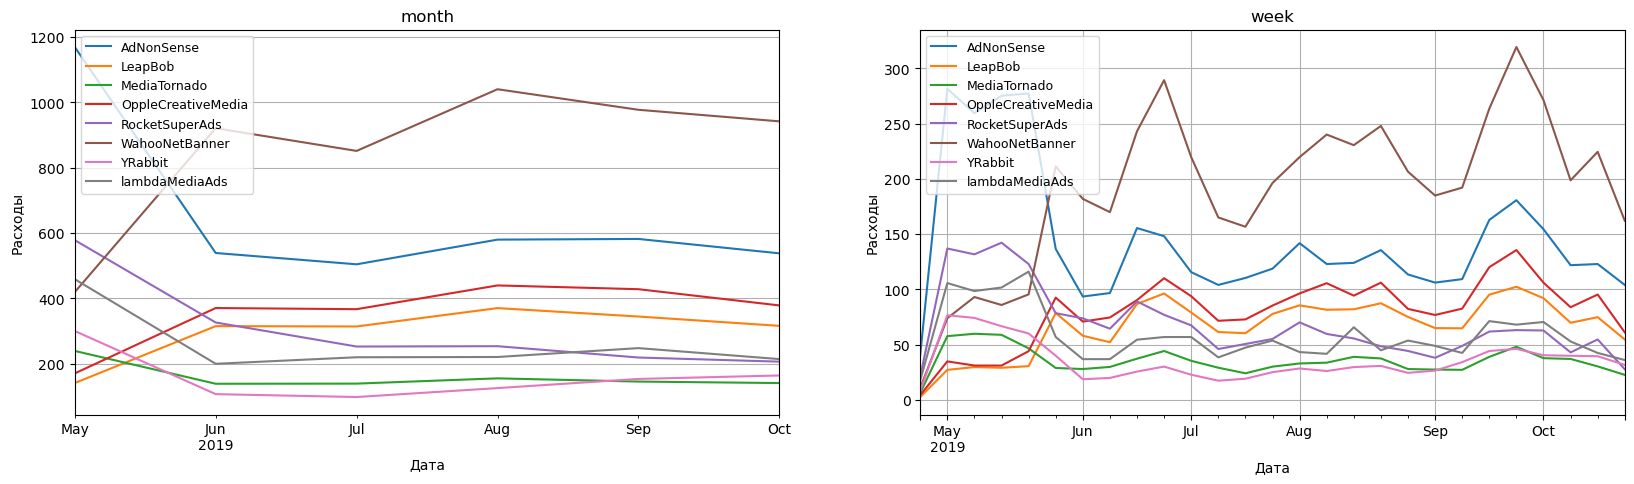

In [43]:
costs2 = costs[(costs.channel != 'FaceBoom') & (costs.channel != 'TipTop')]

plt.subplots(figsize = (20, 5))
for i, col in enumerate(columns):
    costs2.pivot_table(index=col, columns ='channel', values='costs', aggfunc ='sum').plot(grid=True, ax=plt.subplot(1, 2, i + 1))
    plt.title(col)
    plt.legend(fontsize="9", loc ="upper left")
    plt.xlabel('Дата')
    plt.ylabel('Расходы')
plt.show() 

- В июне произошла небольшая корректировка бюджета, и после этого траты на остальные каналы остались практически неизменными.

In [44]:
cac_channel = profiles.groupby('channel')['acquisition_cost'].mean().round(2).sort_values(ascending=False)
cac_channel

channel
TipTop                2.80
FaceBoom              1.11
AdNonSense            1.01
lambdaMediaAds        0.72
WahooNetBanner        0.60
RocketSuperAds        0.41
OppleCreativeMedia    0.25
MediaTornado          0.22
YRabbit               0.22
LeapBob               0.21
organic               0.00
Name: acquisition_cost, dtype: float64

In [45]:
cac_total = (profiles.agg({'acquisition_cost': 'mean'}))
print('Средний САС по всему проекту:', round(cac_total, 2))

Средний САС по всему проекту: acquisition_cost    0.7
dtype: float64


In [46]:
profiles = profiles.query('channel != "organic"')
cac_total_no_organic = (profiles.agg({'acquisition_cost': 'mean'}))
print('Средний САС по всему проекту (без органики):', round(cac_total_no_organic, 2))

Средний САС по всему проекту (без органики): acquisition_cost    1.13
dtype: float64


- TipTop является самым затратным каналом по стоимости привлечения одного покупателя. Все остальные сильно отстают и более чем в два раза дешевле, а также ниже средних значений САС по всему проекту.

### 5. Оценка окупаемости рекламы

Используя графики LTV, ROI и CAC, проанализируем окупаемость рекламы. Считаем, что на календаре 1 ноября 2019 года, а в бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения. Необходимость включения в анализ органических пользователей определим самостоятельно.

- Проанализируем окупаемость рекламы c помощью графиков LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Провертим конверсию пользователей и динамику её изменения. То же самое сделаем с удержанием пользователей. Построим и изучим графики конверсии и удержания.
- Проанализируем окупаемость рекламы с разбивкой по устройствам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализируем окупаемость рекламы с разбивкой по странам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализируем окупаемость рекламы с разбивкой по рекламным каналам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Ответим на такие вопросы:
    - Окупается ли реклама, направленная на привлечение пользователей в целом?
    - Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
    - Чем могут быть вызваны проблемы окупаемости?

In [47]:
observation_date = datetime(2019, 11, 1).date()

In [48]:
#убираем органических пользователей из анализа
profiles = profiles.query('channel != "organic"')

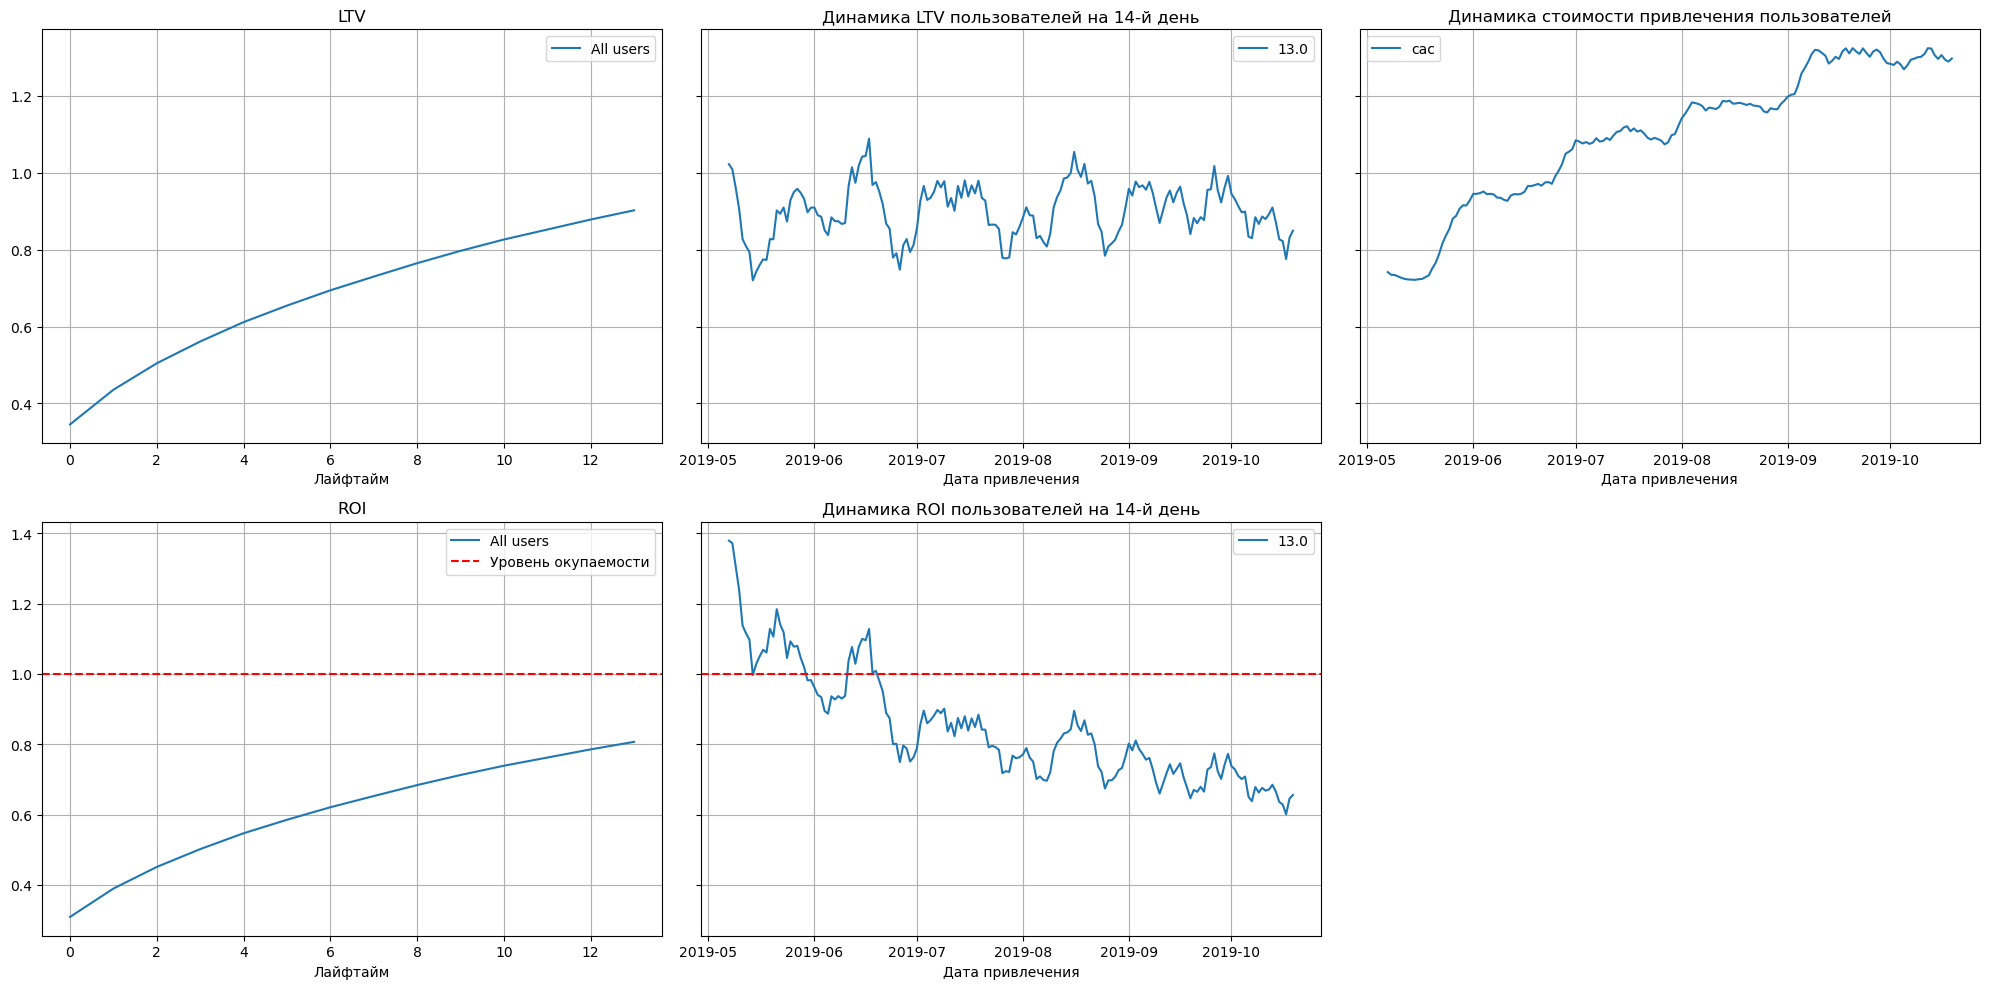

In [49]:
horizon_days = 14

#считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days
)

#строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

- LTV стабильно растет.
- ROI растёт, но до уровня окупаемости не дотягивает.
- Динамика ROI на 14-ый день падает с каждым месяцем.
- САС растёт.

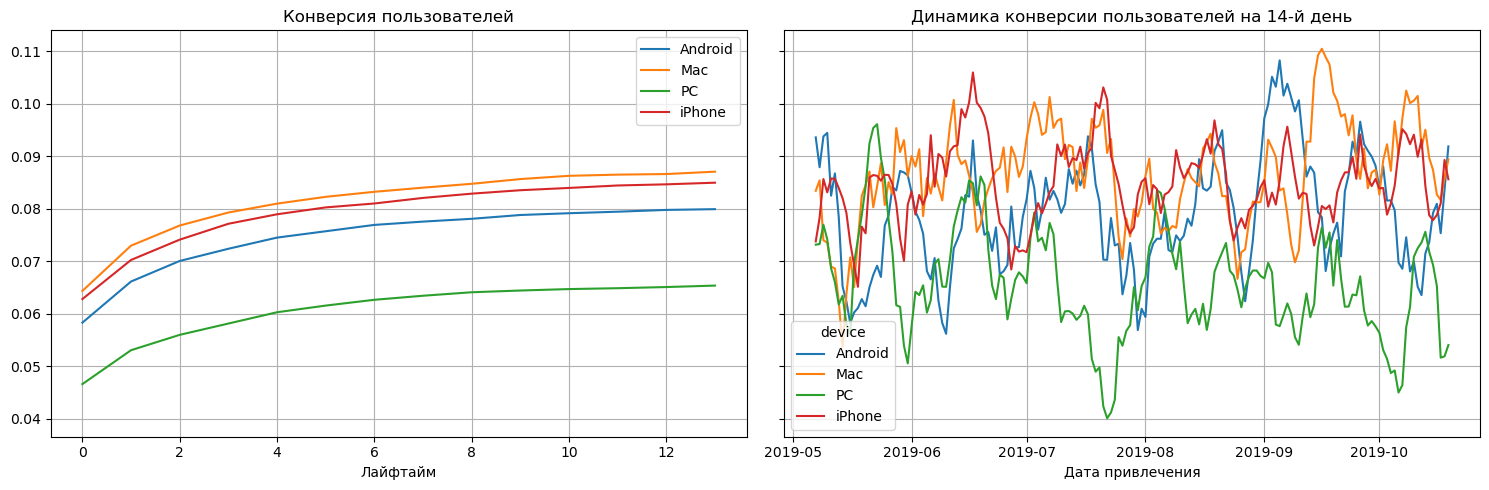

In [50]:
#смотрим конверсию с разбивкой по устройствам

dimensions = ['device']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

- Конверсия у пользователей Android и особенно PC довольно низкая.

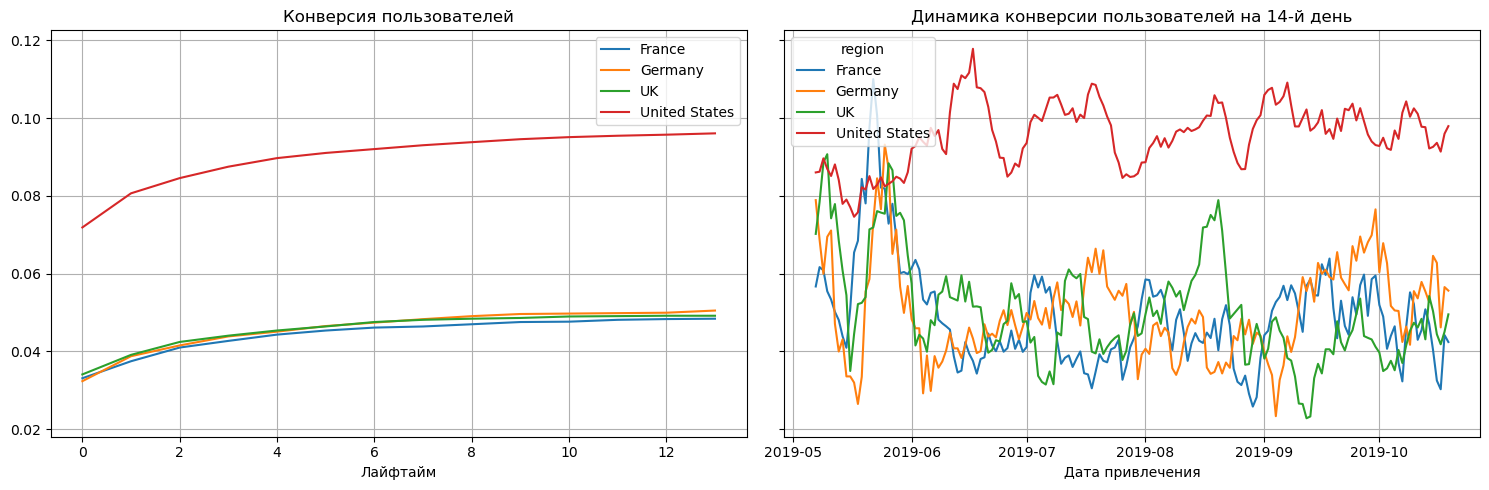

In [51]:
#смотрим конверсию с разбивкой по странам

dimensions = ['region']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

- Конверсия у пользователей из США гораздо выше чем у пользоваталей из остальных стран.

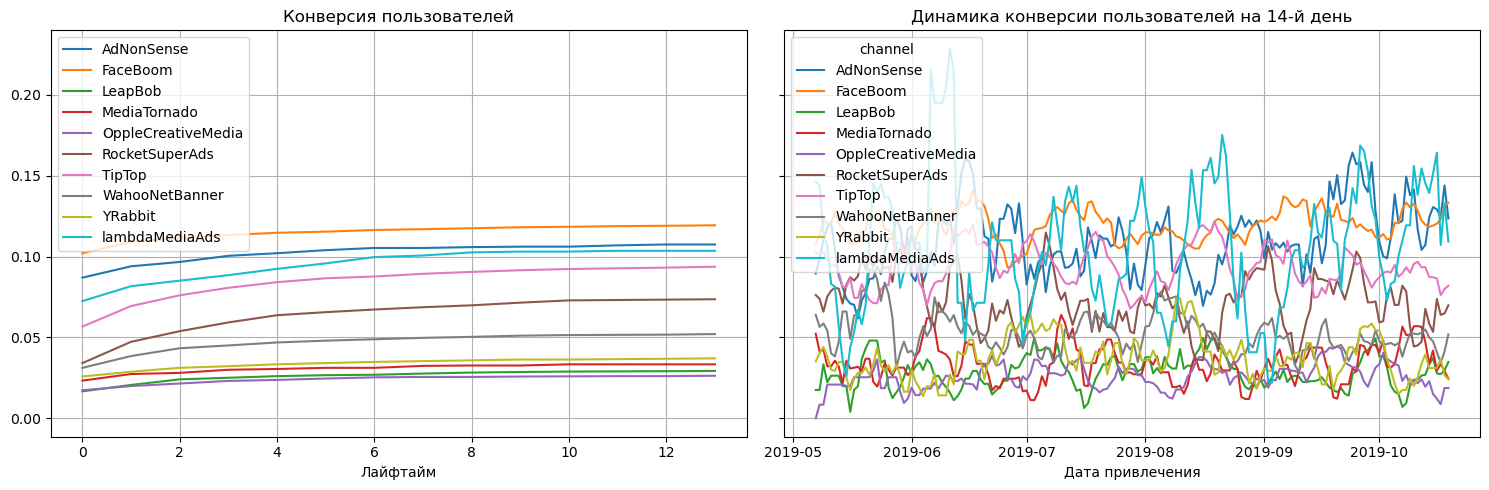

In [52]:
#смотрим конверсию с разбивкой по каналам

dimensions = ['channel']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

- Лучше всего конверсия из FaceBoom.
- MediaTornado, YRabbit, LeapBob и OppleCreativeMedia показывают худшую конверсию.
- Динамика конверсии на 14-ый день у lambdaMediaAds очень нестабильна.

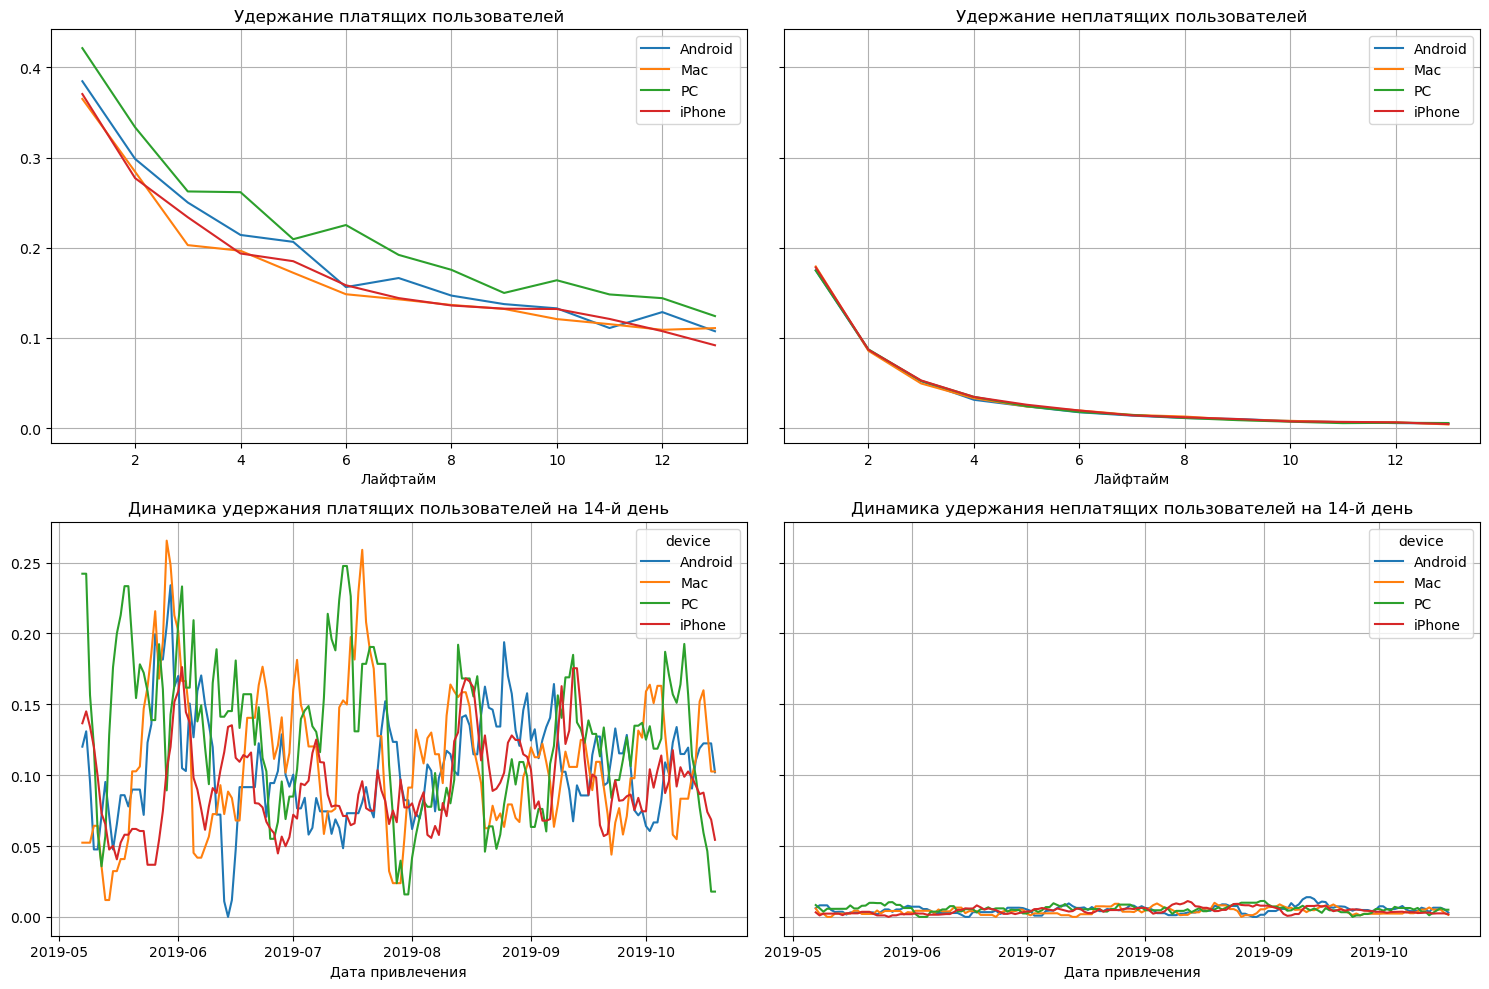

In [53]:
#смотрим удержание с разбивкой по устройствам

dimensions = ['device']

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

- Удержание платящих пользователей PC несколько лучше пользователей остальных устройств.

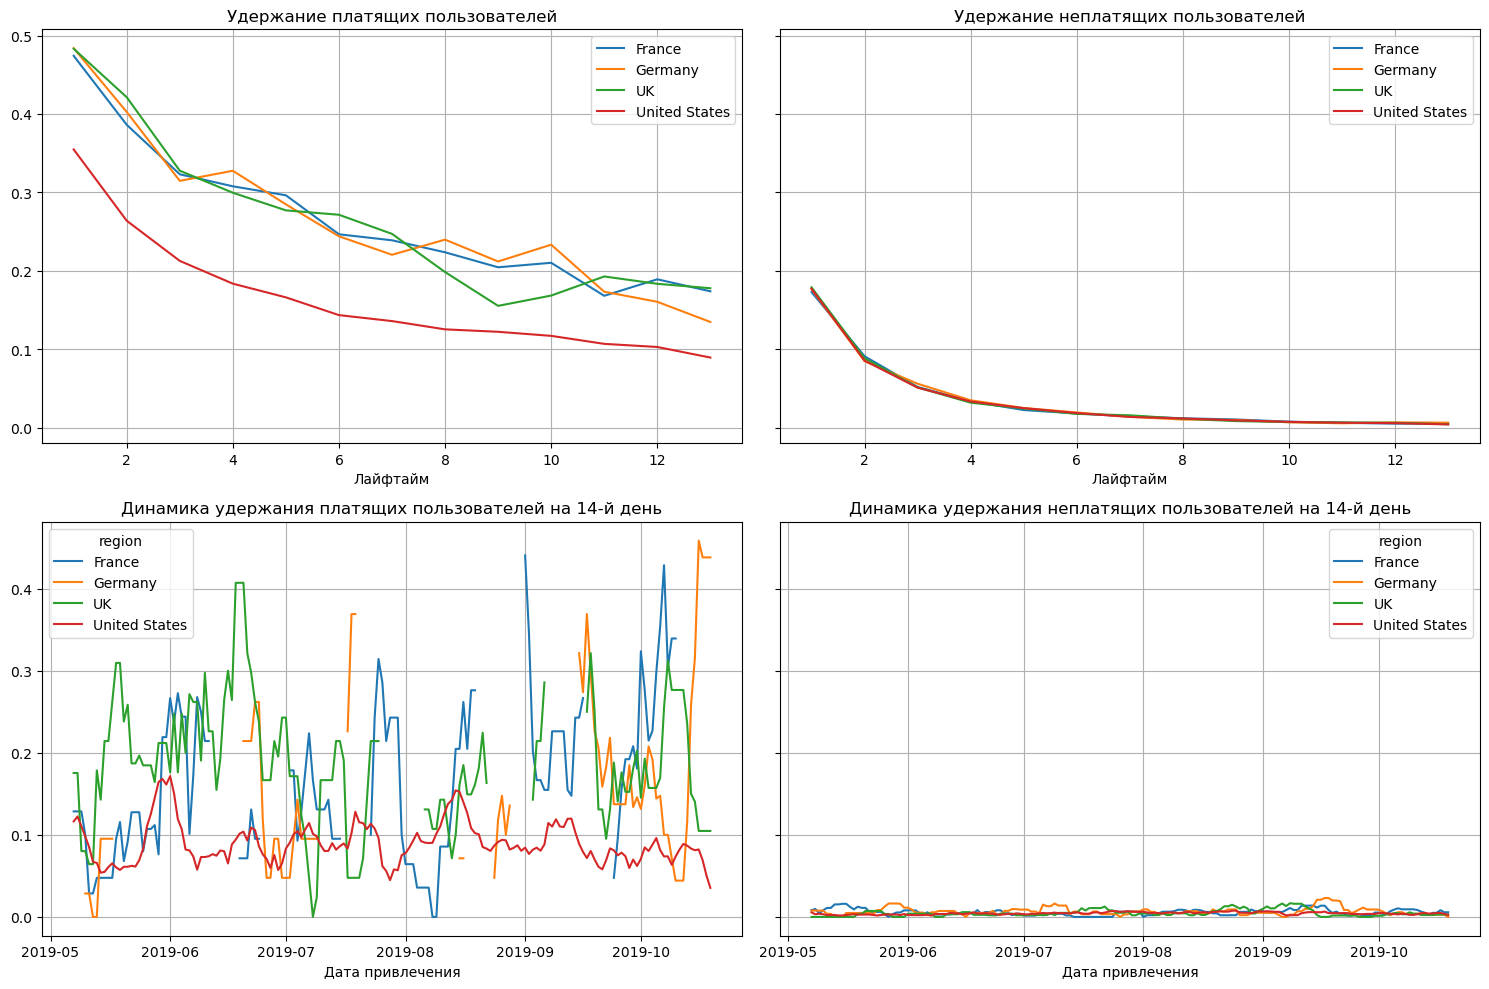

In [54]:
#смотрим удержание с разбивкой по странам

dimensions = ['region']

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

- Удержание платящих пользователей из США самое низкое.

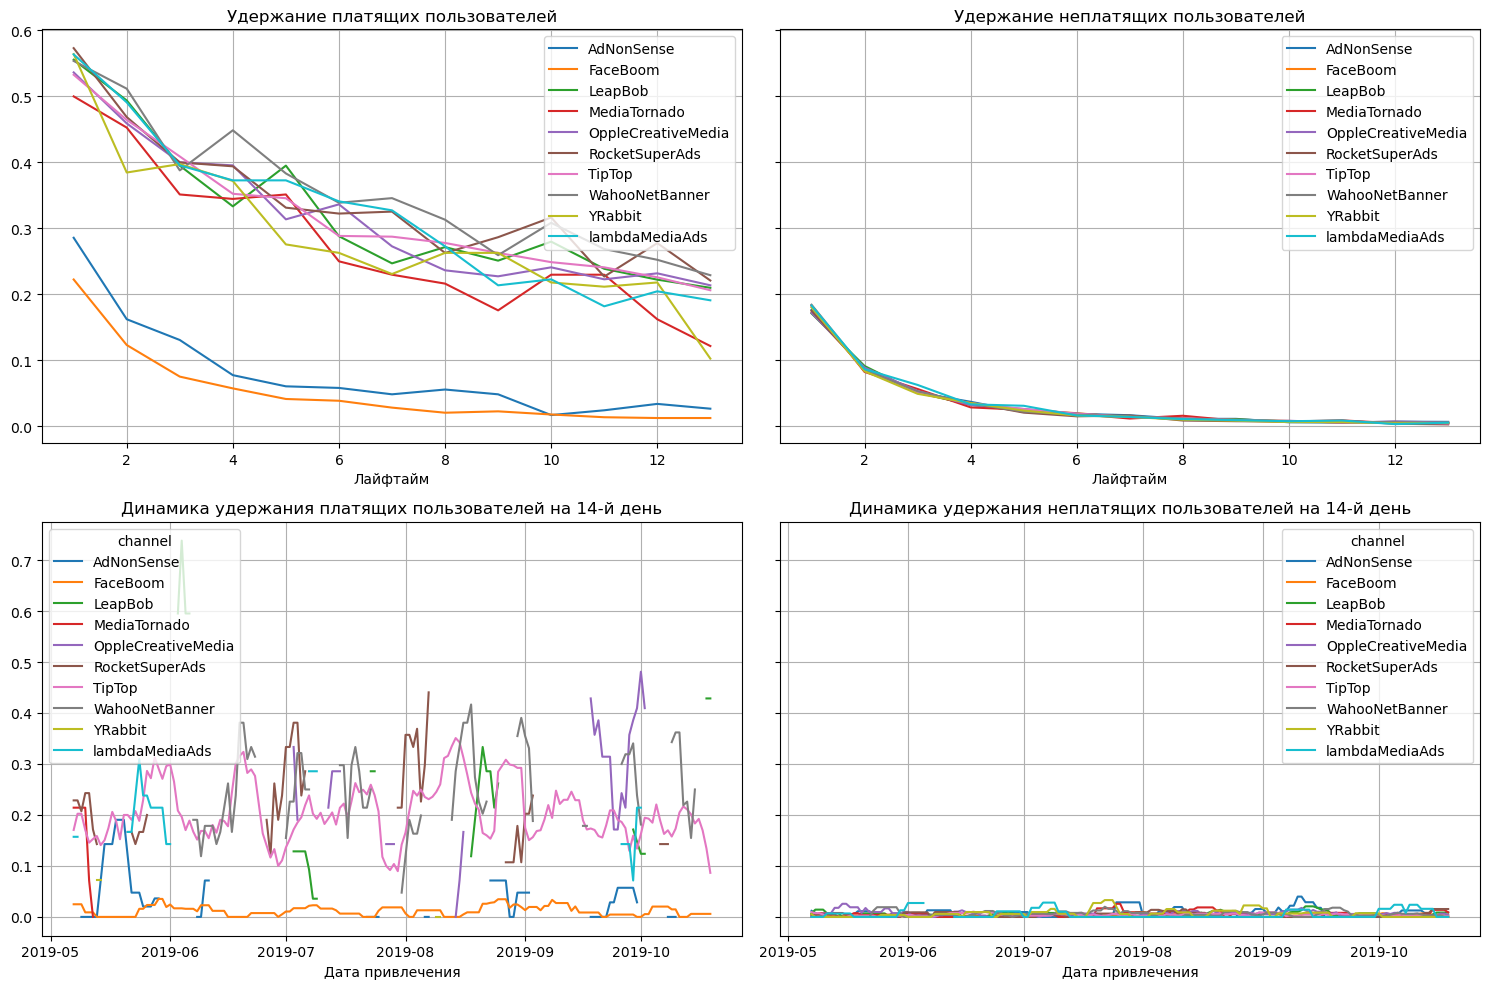

In [55]:
#смотрим удержание с разбивкой по каналам

dimensions = ['channel']

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

- Удержание платящих пользователей из FaceBoom и AdNonSense гораздо ниже чем из остальных источников.

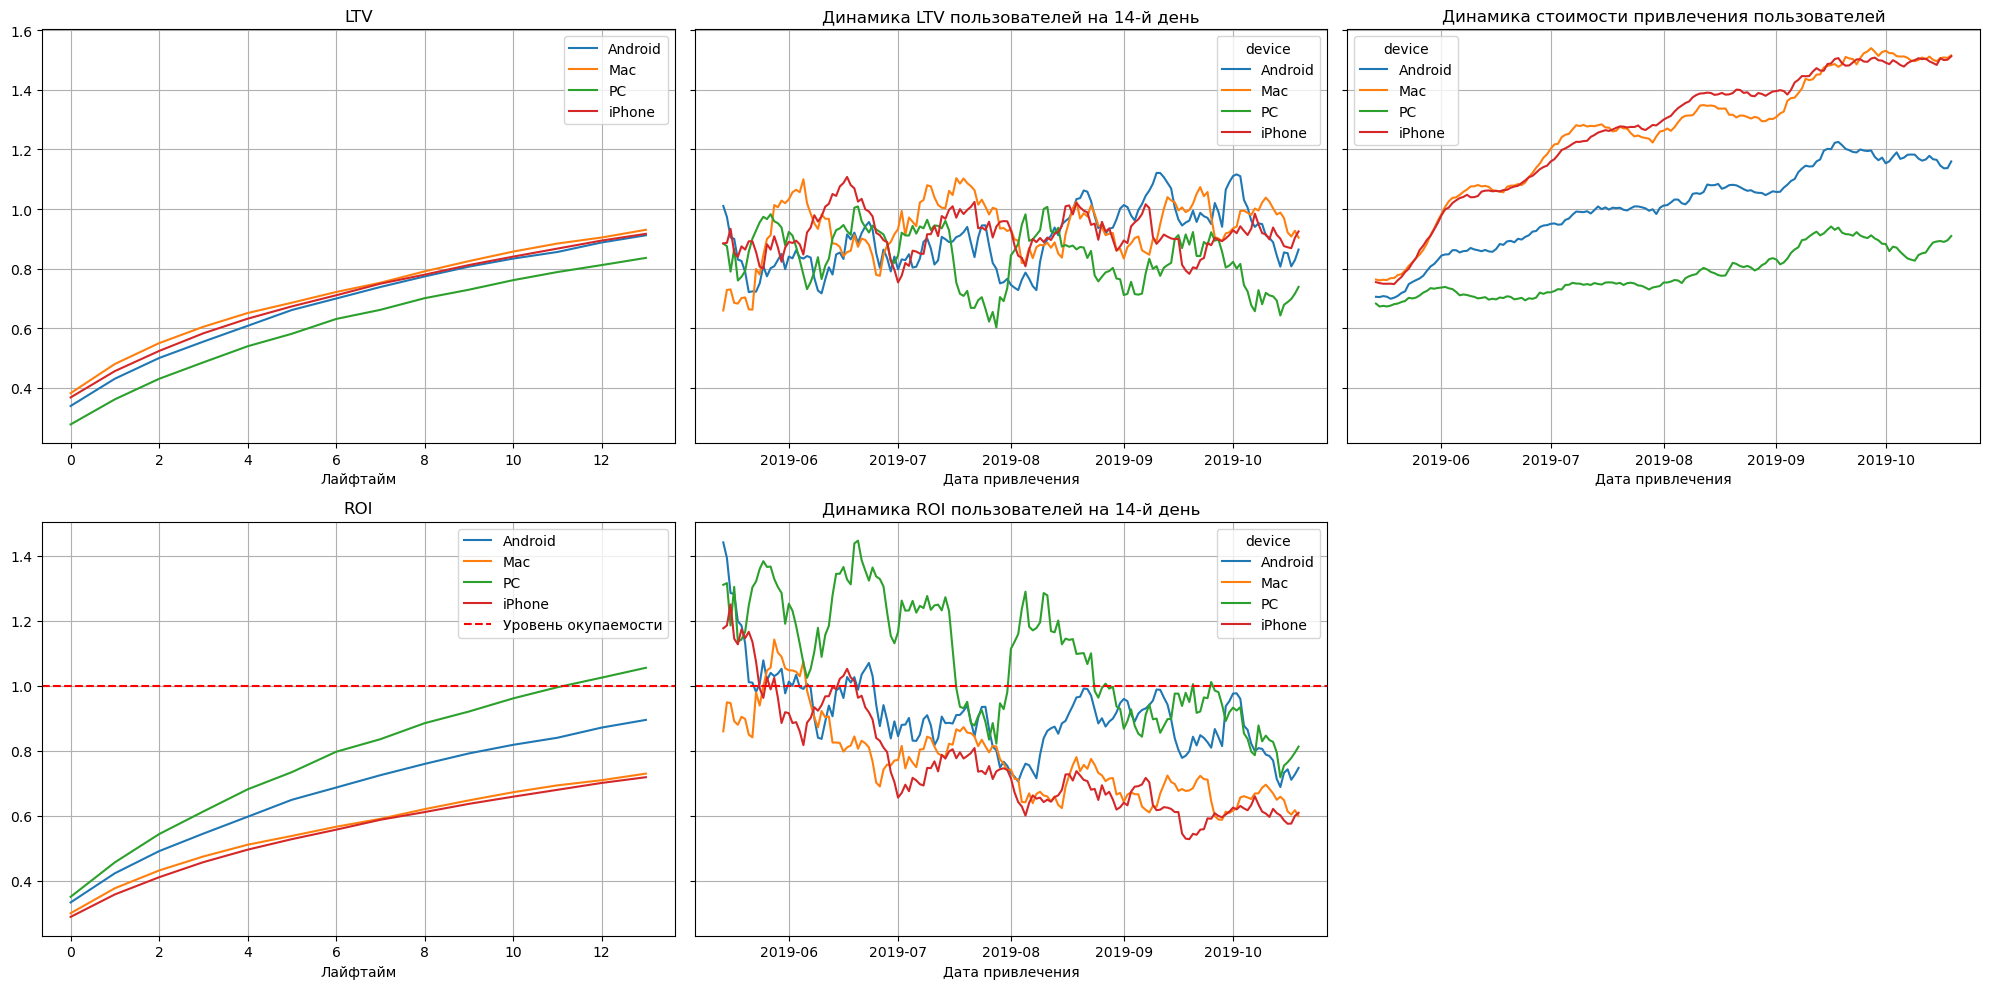

In [56]:
# смотрим окупаемость с разбивкой по устройствам

dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

- LTV пользователей всех устроиств стабильно растёт.
- LTV пользователей PC ниже остальных устройств, но их привлечение самое дешёвое и единственное, которое окупилось.
- Пользователи iPhone и Mac обходятся дороже остальных.
- На 14-ый день окупались только пользователи PC, но с сентября перестали.

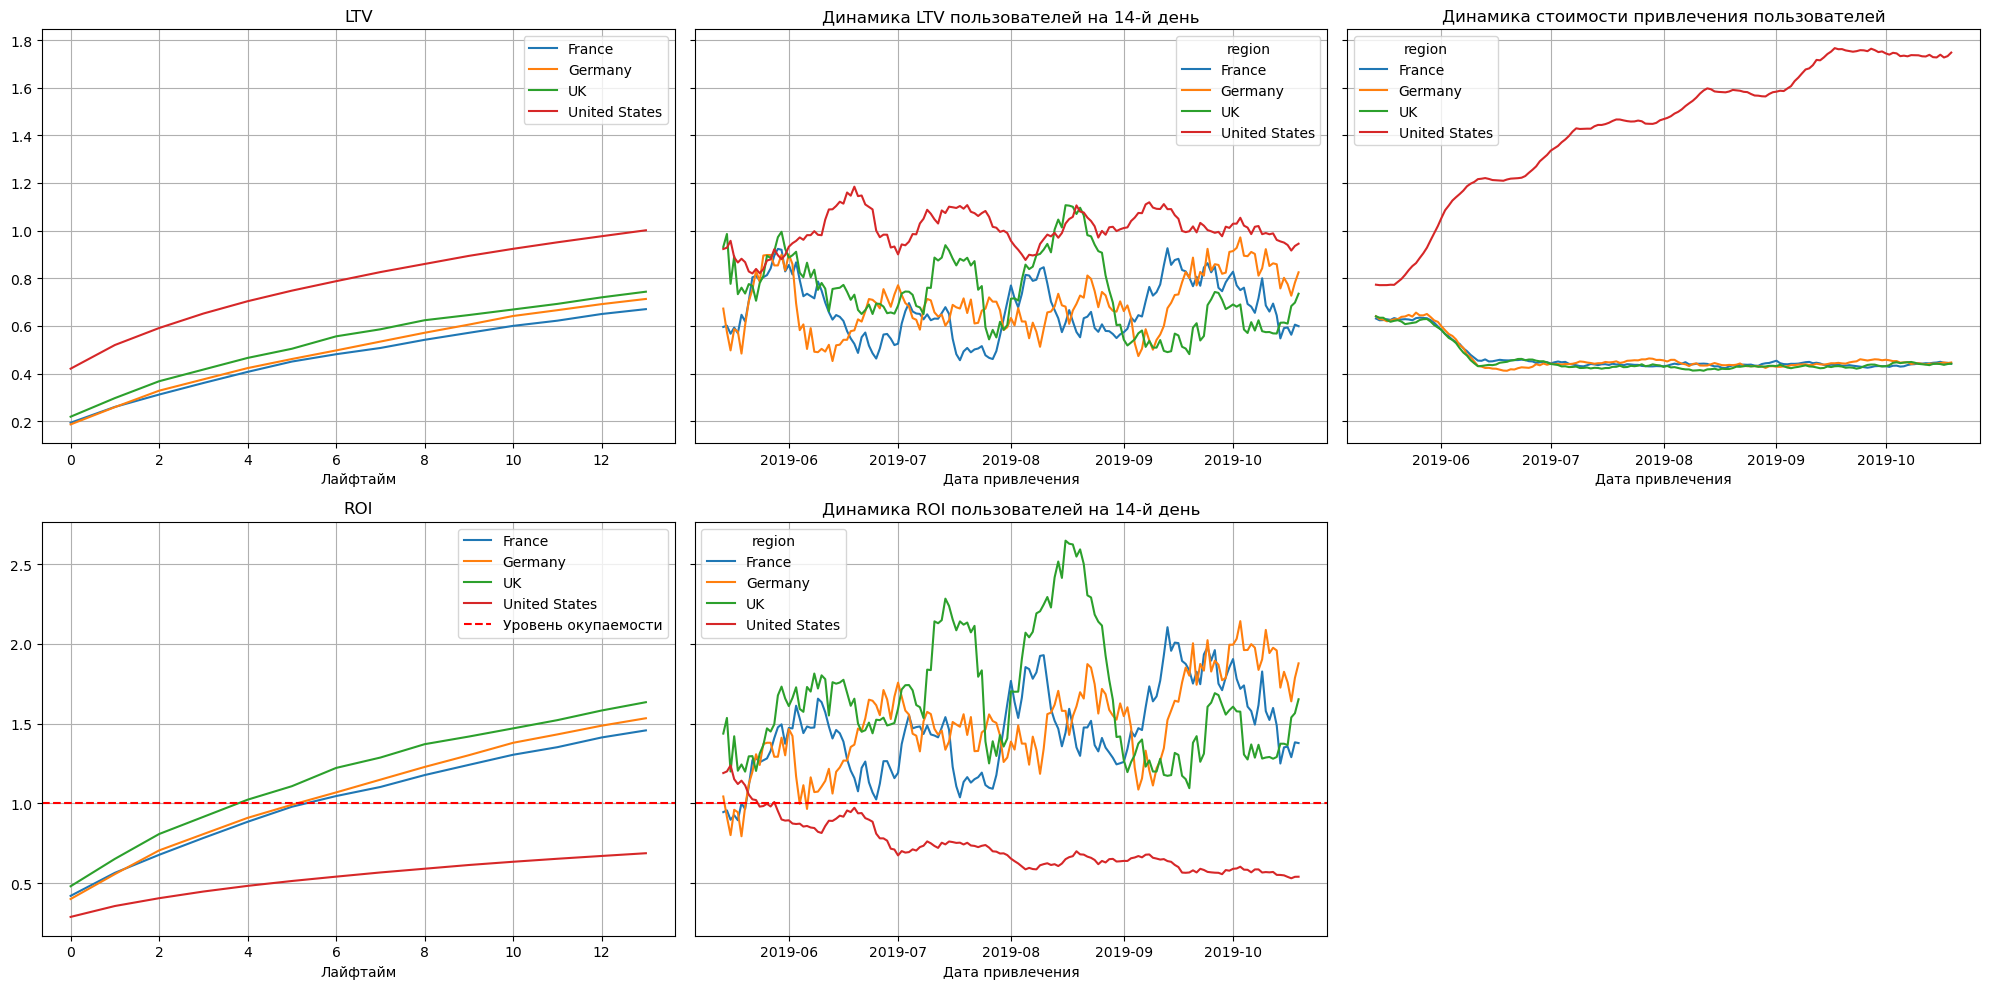

In [57]:
# смотрим окупаемость с разбивкой по странам

dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

- На привлечение пользователей из США тратится всё больше и больше денег, это помогает получить самый высокий LTV, но затраты не окупаются.
- Динамика стоимости привлечения пользоваталей из США показывает существенную разницу в расходах по сравнению с остальными странами.
- Европейскиие пользователи показывают положительную динамику ROI на 14-ый день на протяжении всего исследуемого периода.

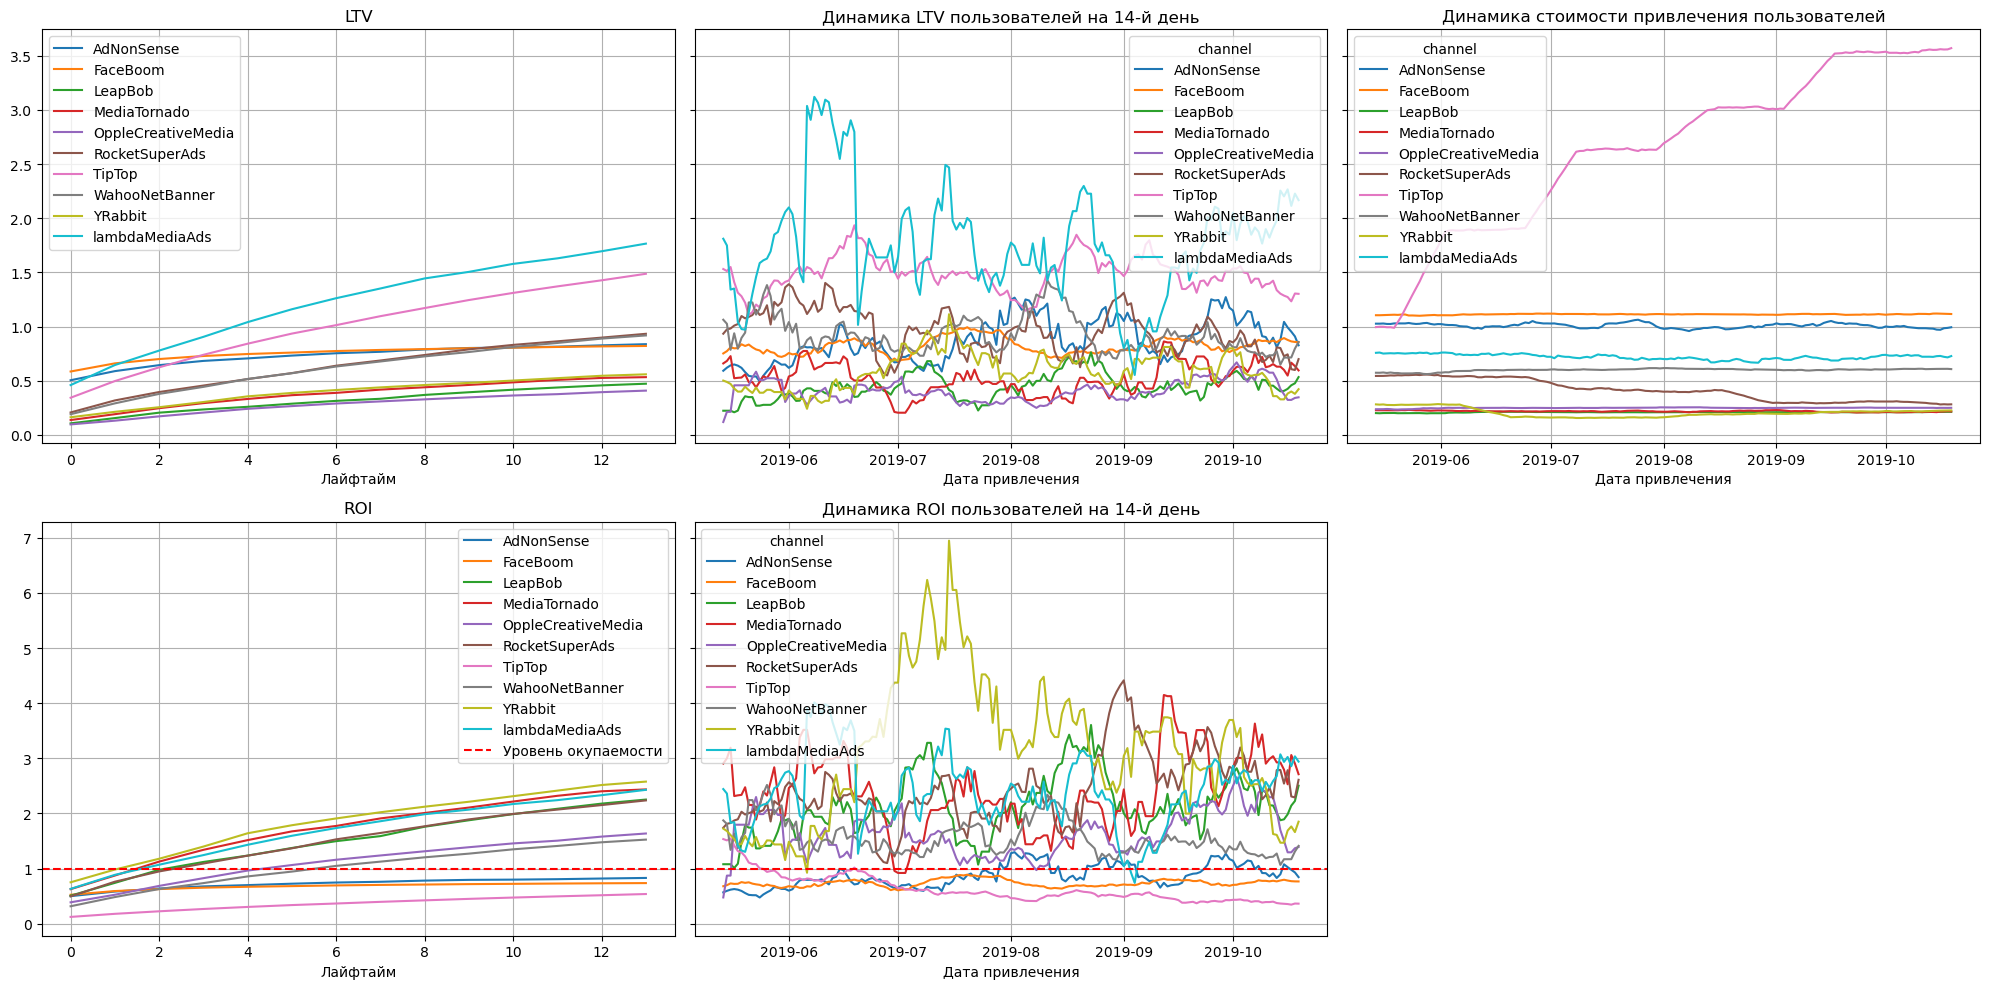

In [58]:
# смотрим окупаемость с разбивкой по каналам

dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

- Самую высокую ценность несут пользователи из lambdaMediaAds и TipTop.
- Динамика стоимости привлечения растёт только у TipTop и очень сильно.
- YRabbit, MediaTornado и lambdaMediaAds показывают самый лучший ROI.
- А вот TipTop, FaceBoom и AdNonSense не окупаются.

*- Окупается ли реклама, направленная на привлечение пользователей в целом?*
- В целом, реклама не окупается, падая к концу второй недели.

*- Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?*
- Самое плохое удержание - у пользователей iPhone. Пользователи из США плохо влияют на окупаемость рекламы. Привлечение пользователей из TipTop очень высокое и расходны не окупаются.

*- Чем могут быть вызваны проблемы окупаемости?*
- Неправильным распределением расходов.

### 6. Общий вывод

- Выделим причины неэффективности привлечения пользователей.
- Сформулируем рекомендации для отдела маркетинга.

Причины неэффективности:
- Привлечение пользоватаелей из США самое дорогое, а удержание платящих пользоваталей оттуда самое низкое.
- То же самое с пользователями из канала TipTop - это самый затратный канал привлечения, а окупаемости нет. 
- Также плохо дело с FaceBoom и AdNonSense. Удержание низкое, окупаемость отсутствует.

Рекомендации:
- Пересмотреть расходы на маркетинг: перестать вкладывать все деньги в те страны и каналы, которые показывают плохую эффективность.
- Обратить внимание на пользователей PC - у них самое лучшее удержание платящих пользователей и они единственные окупаются.
- У пользователей Android тоже есть потенциал. У них второй ROI после PC, а также не самые плохие удержание и конверсия.
- Также стоит обратить внимание на каналы lambdaMediaAds, Yrabbit и MediaTornado. У них лучший ROI.